## <center>基于图神经网络的好友推荐算法</center>

本项目基于node2vec，在lastfm数据集上实现一个好友推荐算法。

### 一、构建网络

基于snap库，为lastfm数据集构建图结构。其中节点表示用户，边表示用户的好友关系。

In [1]:
import snap
import json

path = "./lasftm_asia/" #使用lasftm_asia数据集（LastFM用户的社交网络）
with open(path + 'lastfm_asia_features.json') as file:
    data = json.load(file)
    
#根据节点特征计算权重
def get_weight(data, node1, node2):
    corr_likes = sum([1 for x in data[str(node1)] if x in data[str(node2)]])
    return 1 + (corr_likes + 1) / (len(data[str(node1)]) + 1)

#构建无向图
graph = snap.TUNGraph.New()
nodes = []
edges_total = 0
edge_weights = {}
with open(path + 'lastfm_asia_edges.csv', 'r') as file:
    lines = file.read().splitlines()
    for line in lines[1:]:
        row = line.split(',')
        node1 = int(row[0])
        node2 = int(row[1])
        if node1 not in nodes:
            nodes.append(node1)
            graph.AddNode(node1)
        if node2 not in nodes:
            nodes.append(node2)
            graph.AddNode(node2)
        graph.AddEdge(node1, node2)
        edge_weights[(node1, node2)] = get_weight(data, node1, node2)
        edge_weights[(node2, node1)] = get_weight(data, node1, node2)
        edges_total += 1
nodes_total = len(nodes)
print("节点数:", nodes_total)
print("边数", edges_total)

节点数: 7624
边数 27806


### 二、构建随机游走函数

实现node2vec的二阶随机游走函数，用于提取节点的共现信息。

In [2]:
import random

#随机选择下一个节点
def choose_next(graph, data, prev_node, cur_node, neighbors, p, q):
    probs = []
    for n in neighbors:
        w = data[(cur_node, n)]
        if n == prev_node:
            w *= 1 / p
        elif n in [node for node in graph.GetNI(cur_node).GetOutEdges()]:
            w *= 1
        else:
            w *= 1 / q
        probs.append((n, w))
    total_w = sum(i for _, i in probs)
    rand = random.uniform(0, total_w)
    cw = 0
    for n, w in probs:
        cw += w
        if rand < cw:
            return n

#实现随机游走
def random_walk(graph, node, data, length = 10, p = 1, q = 1):
    walk = [node]
    prev_node = None
    cur_node = node
    for i in range(length - 1):
        neighbors = [node for node in graph.GetNI(cur_node).GetOutEdges()]
        if not neighbors:
            break
        elif prev_node is None:
            next_node = random.choice(neighbors)
        else:
            next_node = choose_next(graph, data, prev_node, cur_node, neighbors, p, q)
        walk.append(next_node)
        prev_node = cur_node
        cur_node = next_node
    return walk

#生成随机游走路径
walks = []
for node in range(graph.GetNodes()):
    walks.append(random_walk(graph, node, edge_weights, 5, 0.5, 0.7))

### 三、学习并获取节点嵌入

将各个节点的随机游走路径输入到word2vec模型中，获取节点的嵌入表示。

In [3]:
from gensim.models import Word2Vec

#使用word2vec模型
def learn_embedding(walks, size = 128, window = 5, epochs = 30):
    model = Word2Vec(sentences = walks, vector_size = size, window = window, min_count = 0, sg = 1, epochs = epochs)
    return model

#获取节点嵌入表示
def node_embedding(model, node):
    return model.wv[node]

model = learn_embedding(walks)
features = model.wv.vectors
print(features.shape)

(7624, 128)


### 四、计算相似度

利用节点嵌入表示的余弦相似度来衡量节点之间的相似性，根据相似性进行好友推荐。

In [4]:
import numpy
from matplotlib import pyplot as plt

class Friend:
    def __init__(self, index, similarity, is_friend):
        self.index = index
        self.similarity = similarity
        self.is_friend = is_friend

#计算余弦相似度
def cos_similarity(node1, node2):
    norm1 = numpy.linalg.norm(node1)
    norm2 = numpy.linalg.norm(node2)
    if norm1 == 0 or norm2 == 0:
        return 0
    else:
        return numpy.dot(node1, node2) / (norm1 * norm2)

#进行好友推荐
def recomm_friends(graph, node, nodes_total, features, threshold = 0):
    new_friends = []
    all_friends = []
    neighbors = [n for n in graph.GetNI(node).GetOutEdges()]
    for n in range(nodes_total):
        if n != node:
            sim = cos_similarity(features[n], features[node])
            if n not in neighbors:
                all_friends.append(Friend(n, sim, False))
                if sim >= threshold:
                    new_friends.append(Friend(n, sim, False))
            else:
                all_friends.append(Friend(n, sim, True))
    print(f"推荐好友数：{len(new_friends)}，全体用户数：{len(all_friends)}")
    new_friends = sorted(new_friends, key = lambda x: x.similarity, reverse = True)
    all_friends = sorted(all_friends, key = lambda x: x.similarity, reverse = True)
    return new_friends, all_friends

#根据数量推荐好友
new_friends, _ = recomm_friends(graph, 13, nodes_total, features)
for i in range(10):
    print(f"推荐好友id：{new_friends[i].index}，相似度：{new_friends[i].similarity}")
print("\n")
#根据阈值推荐好友
new_friends, _ = recomm_friends(graph, 13, nodes_total, features, 0.75)
for i in range(len(new_friends)):
    print(f"推荐好友id：{new_friends[i].index}，相似度：{new_friends[i].similarity}")

推荐好友数：7594，全体用户数：7623
推荐好友id：172，相似度：0.9758290648460388
推荐好友id：154，相似度：0.9733244776725769
推荐好友id：228，相似度：0.971437931060791
推荐好友id：108，相似度：0.971419095993042
推荐好友id：65，相似度：0.9713624715805054
推荐好友id：107，相似度：0.9699846506118774
推荐好友id：129，相似度：0.9695513248443604
推荐好友id：137，相似度：0.9695311188697815
推荐好友id：126，相似度：0.9677109122276306
推荐好友id：138，相似度：0.9676443338394165


推荐好友数：489，全体用户数：7623
推荐好友id：172，相似度：0.9758290648460388
推荐好友id：154，相似度：0.9733244776725769
推荐好友id：228，相似度：0.971437931060791
推荐好友id：108，相似度：0.971419095993042
推荐好友id：65，相似度：0.9713624715805054
推荐好友id：107，相似度：0.9699846506118774
推荐好友id：129，相似度：0.9695513248443604
推荐好友id：137，相似度：0.9695311188697815
推荐好友id：126，相似度：0.9677109122276306
推荐好友id：138，相似度：0.9676443338394165
推荐好友id：634，相似度：0.9670146703720093
推荐好友id：191，相似度：0.9669622182846069
推荐好友id：438，相似度：0.9663345813751221
推荐好友id：197，相似度：0.9655259251594543
推荐好友id：286，相似度：0.9653444886207581
推荐好友id：118，相似度：0.9650641679763794
推荐好友id：433，相似度：0.9647186994552612
推荐好友id：166，相似度：0.9641907215118408
推荐好友id：26

### 五、数据可视化

对相似度进行可视化，验证好友推荐算法的有效性。

推荐好友数：7594，全体用户数：7623


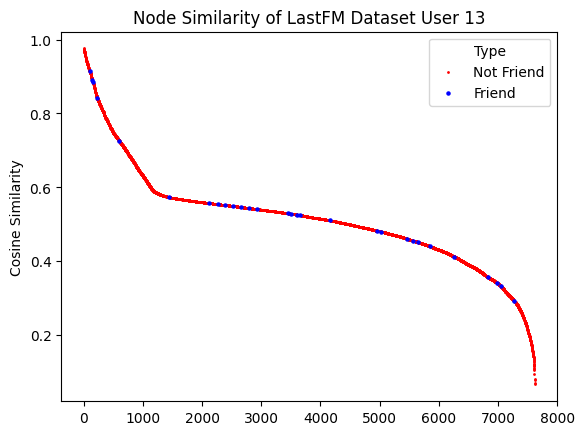

In [5]:
from matplotlib import pyplot as plt

def show_friends(graph, node, nodes_total, features, threshold = 0):
    _, all_friends = recomm_friends(graph, node, nodes_total, features, threshold)
    friend = []
    not_friend = []
    for i, x in enumerate(all_friends):
        if x.is_friend:
            friend.append((i, x.similarity))
        else:
            not_friend.append((i, x.similarity))
    x1, y1 = zip(*friend) if friend else ([], [])
    x2, y2 = zip(*not_friend) if not_friend else ([], [])
    plt.scatter(x2, y2, color = "red", s = 1, label = "Not Friend")
    plt.scatter(x1, y1, color = "blue", s = 5, label = "Friend")
    plt.title(f"Node Similarity of LastFM Dataset User {node}")
    plt.ylabel("Cosine Similarity")
    plt.legend(title = "Type")
    plt.show()

show_friends(graph, 13, nodes_total, features)